<a href="https://colab.research.google.com/github/ali-rabiee/Decoding-Grasping-Movements-Analysis-and-Comparison-of-EEG-and-tEEG/blob/main/ML_4chTripolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import scipy.io.wavfile
import scipy.signal
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt, iirnotch
import zipfile
import warnings
import pywt
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Feature Extraction and Classification

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis

# This function prepare the X_train, X_test, y_train, y_test
def prepare_data(df, labels, win_size=1501, time_win=(0, None), balance=False):

    X = []
    y = []

    start, end = time_win
    for i in range(0, len(df), win_size):
        x = df[i:i+win_size].values

        # Applying the time window to select a specific range of rows
        x = x[start:end]
        X.append(x)
        y.append(labels[i])

    X, y = np.array(X), np.array(y)

    # Shuffle data
    # X, y = shuffle(X, y)
    if balance:
    # Balance the dataset
        oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = oversampler.fit_resample(X.reshape(-1, X.shape[1]*X.shape[2]), y)
        X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled, y_resampled
    else:
        return X, y


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def report_classification_metrics(y_true, y_pred, average_type='macro'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average_type)
    recall = recall_score(y_true, y_pred, average=average_type)
    f1 = f1_score(y_true, y_pred, average=average_type)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

def extract_statistical_features_from_amplitude(coefficients):
    """Extract statistical features from the amplitude of wavelet coefficients."""
    amplitude = np.abs(coefficients.flatten())  # Get the amplitude and flatten

    # Extract features from amplitude
    mean_amp = np.mean(amplitude)
    variance_amp = np.var(amplitude)
    skewness_amp = skew(amplitude)
    kurtosis_amp = kurtosis(amplitude)

    return [mean_amp, variance_amp, skewness_amp, kurtosis_amp]

def get_amplitude_features_for_data(X, wavelet='cmor', max_scale=50):
    all_features = []

    # For each instance in X
    for instance in X:
        instance_features = []

        # For each channel-frequency band pair in the instance
        for column in range(instance.shape[1]):
            coefficients, _ = pywt.cwt(instance[:, column], scales=np.arange(1, max_scale+1), wavelet=wavelet)

            # Extract statistical features from the amplitude
            amp_features = extract_statistical_features_from_amplitude(coefficients)
            instance_features.extend(amp_features)

        all_features.append(instance_features)

    return np.array(all_features)

## Visualizing the Features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def average_wavelet_coefficients(X, wavelet='morl', scales=np.arange(1, 128), sr=250):
    coefficients_list = []

    # For each instance in X
    for instance in X:
        instance_coefficients = []

        # For each channel in the instance
        for column in range(instance.shape[1]):
            coefficients, freqs = pywt.cwt(instance[:, column], scales=scales, wavelet=wavelet, sampling_period=1/sr)
            instance_coefficients.append(np.abs(coefficients)**2)

        coefficients_list.append(instance_coefficients)

    # Average across all instances
    avg_coefficients = np.mean(coefficients_list, axis=0)
    return avg_coefficients, freqs

def scale_to_freq(scale, sampling_rate=250.0, cf=0.8491):
    """Converts wavelet scale to frequency."""
    return cf / scale * sampling_rate

In [ ]:
from preprocessing import *

# Set the path for this subject
path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject1/task_3"

df_2 = read_data_and_preprocessing(path, events=[1], denoise=0, detrend=True, low_f=1, high_f=40, FreqBands=False, minmax=False, zscore=True)

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))

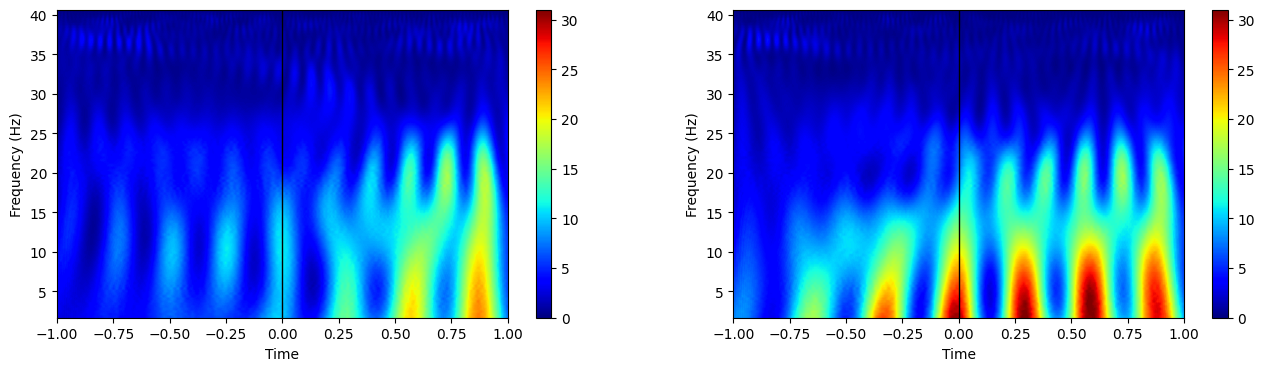

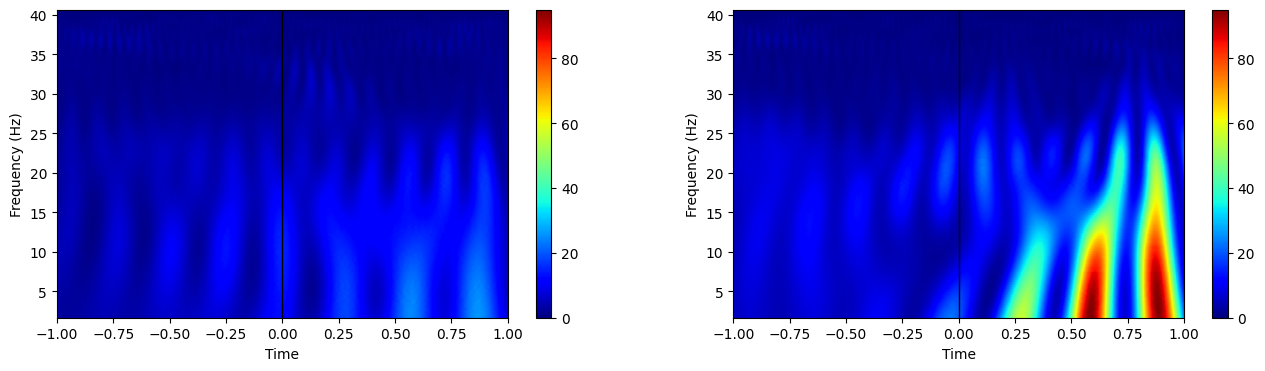

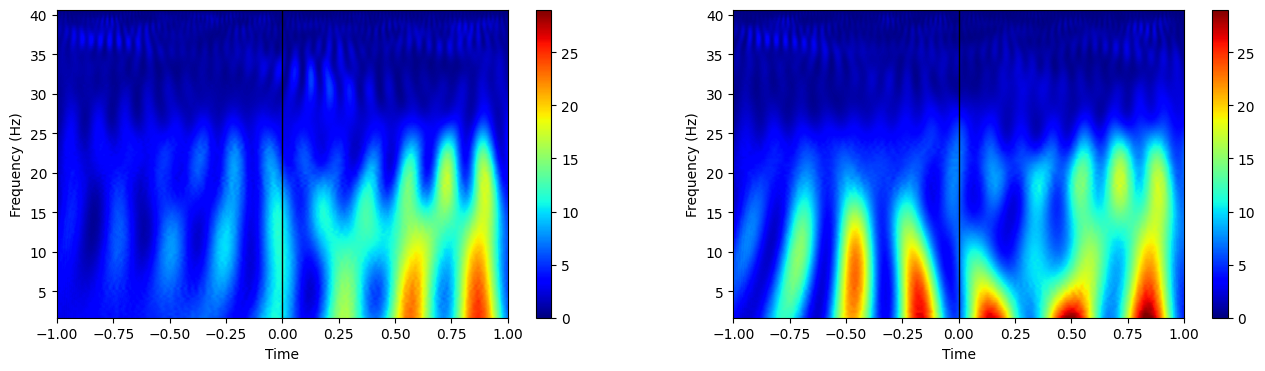

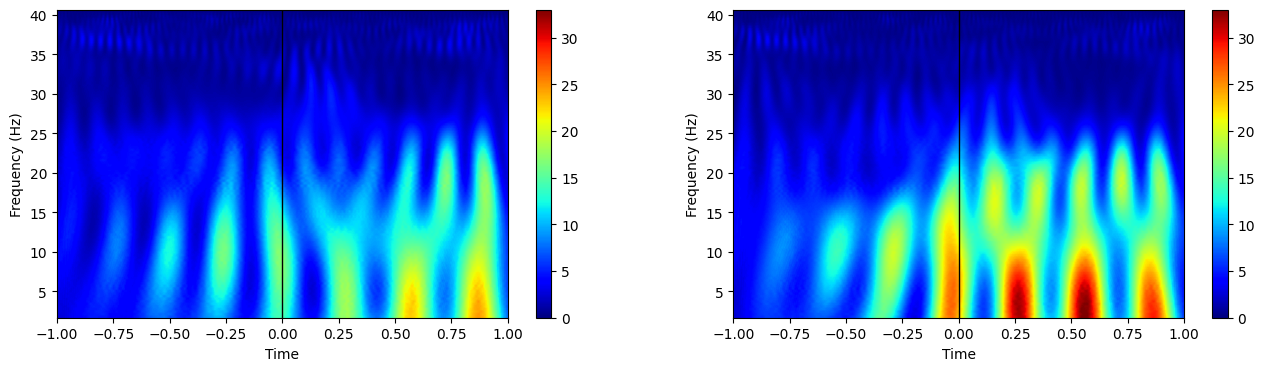

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)
# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

In [ ]:
from preprocessing import *

# Set the path for this subject
path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject1/task_3"

df_2 = read_data_and_preprocessing(path, events=[2], denoise=0, detrend=True, low_f=1, high_f=40, FreqBands=False, minmax=False, zscore=True)

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))

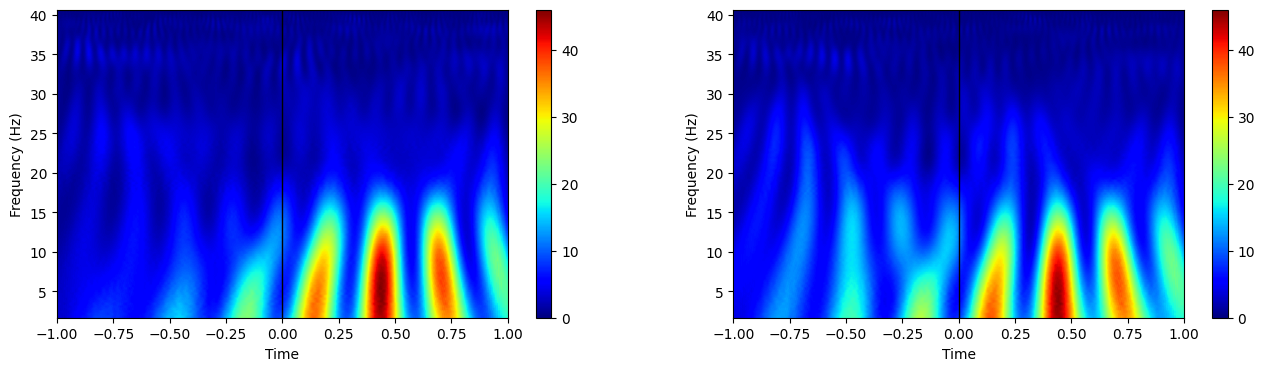

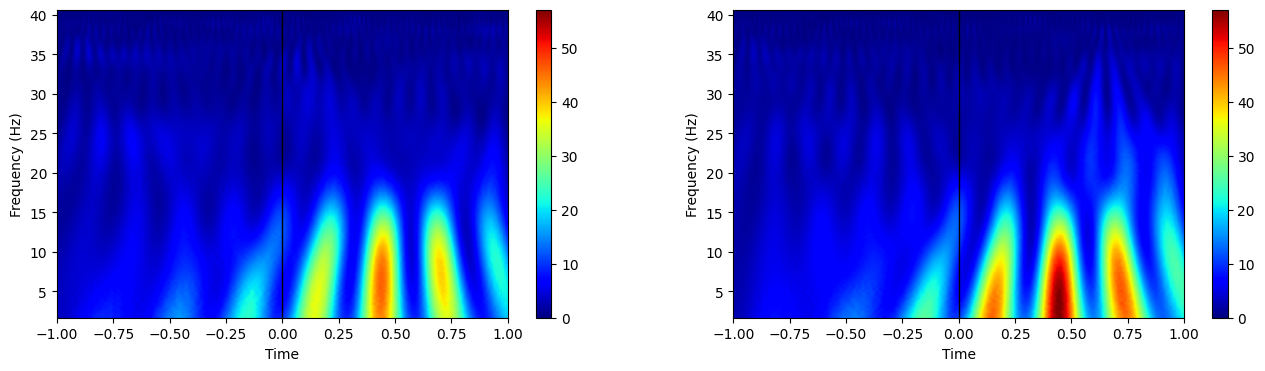

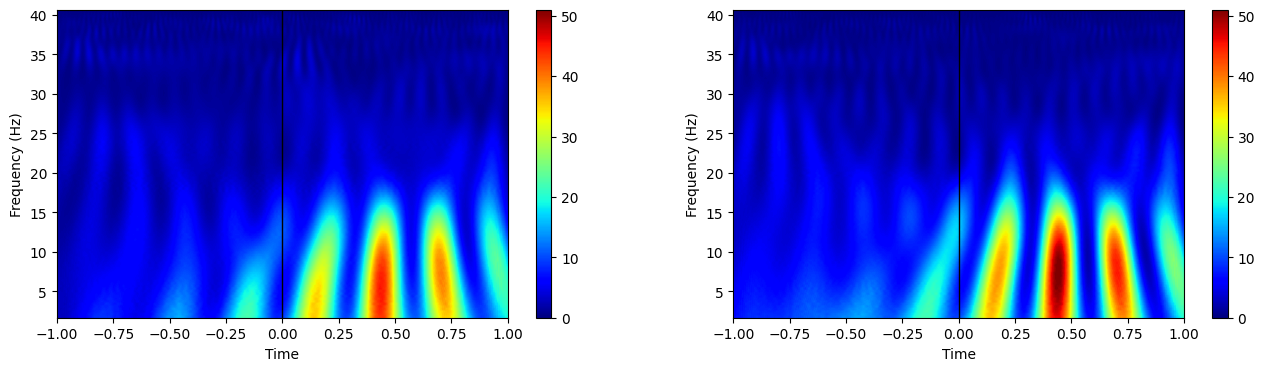

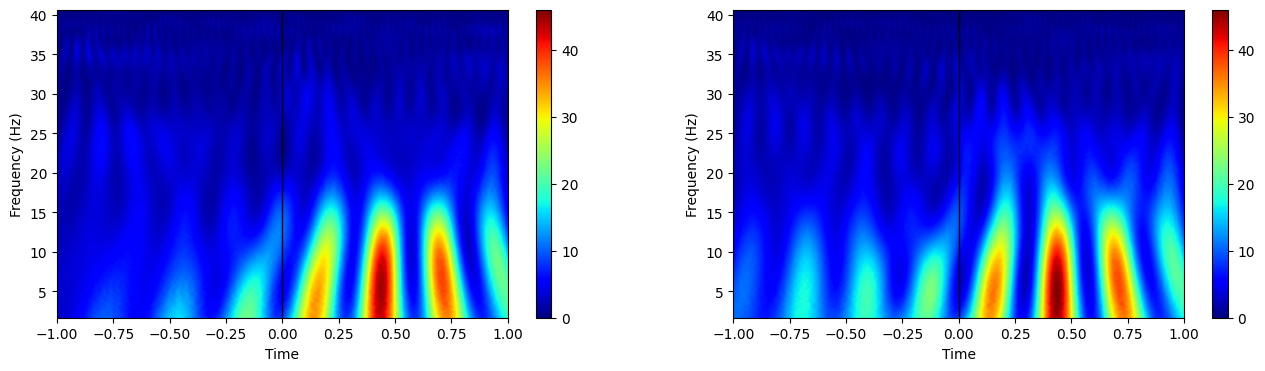

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)
# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

In [ ]:
from preprocessing import *

# Set the path for this subject
path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject1/task_3"

df_2 = read_data_and_preprocessing(path, events=[0], denoise=0, detrend=True, low_f=1, high_f=40, FreqBands=False, minmax=False, zscore=True)

labels_2 = df_2["events"].to_list()
df_2.drop(['events'], axis=1, inplace=True)

df_tcre_2 = df_2.loc[:, ['P3_t', 'C3_t', 'C4_t', 'F5_t']]
df_eeg_2 = df_2.loc[:, ['P3_e', 'C3_e', 'C4_e', 'F5_e']]

X_eeg_2, _ = prepare_data(df_eeg_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))
X_tcre_2, _ = prepare_data(df_tcre_2, win_size=1501, labels=labels_2, time_win=((501, 1001)))

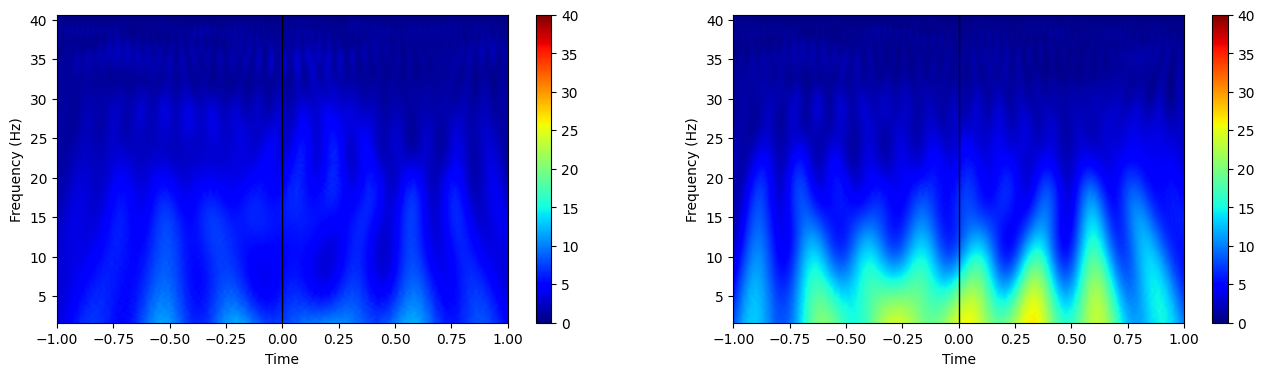

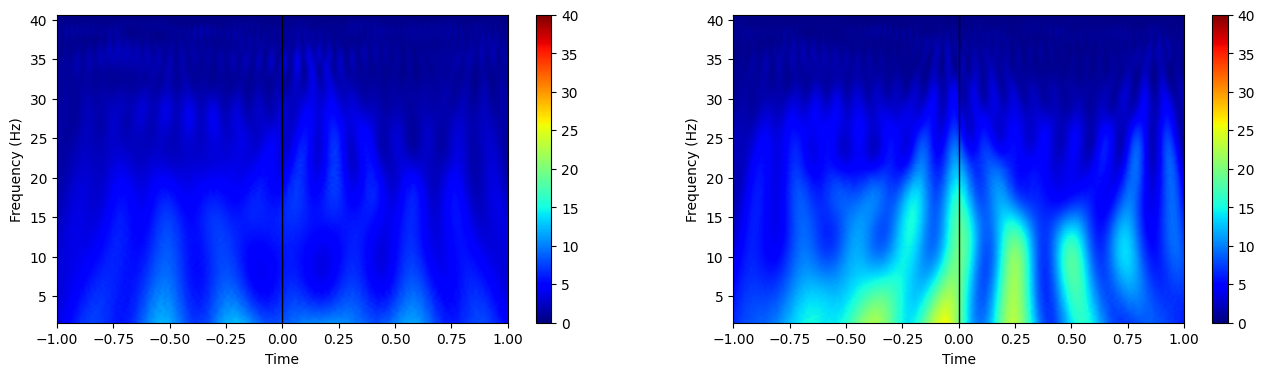

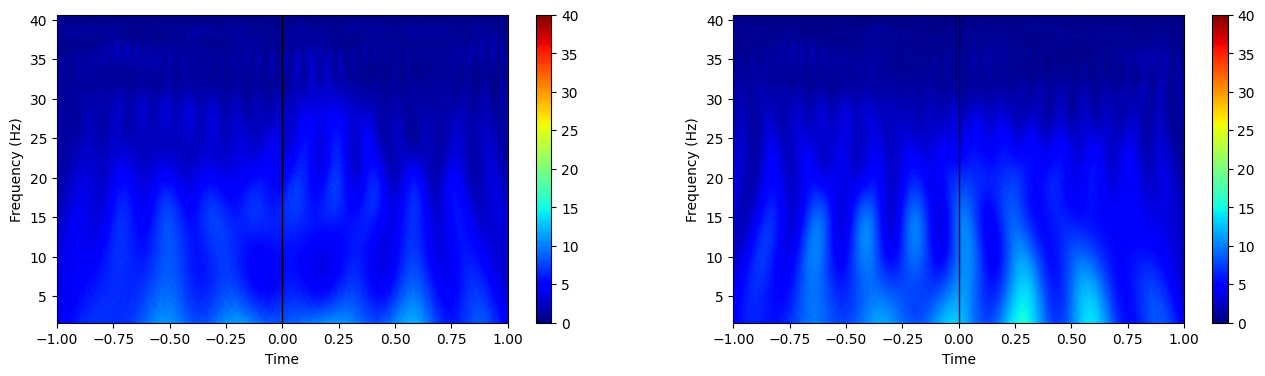

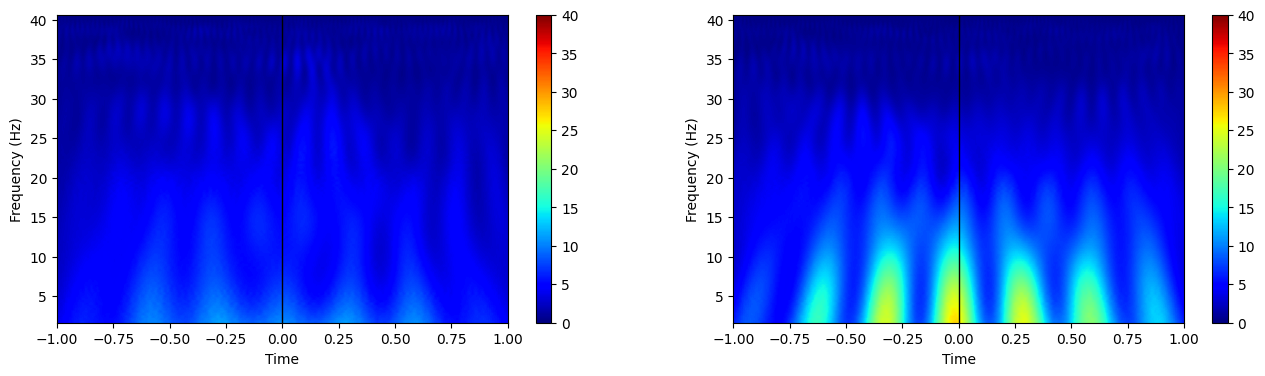

In [ ]:
sampling_rate = 250
scales = np.arange(5, 125)
# scales = np.logspace(2, 64, num=64, base=10) / sampling_rate
wavelet = 'morl'

eeg_avg_coeffs, frequencies = average_wavelet_coefficients(X_eeg_2, wavelet=wavelet, scales=scales)
teeg_avg_coeffs, _ = average_wavelet_coefficients(X_tcre_2, wavelet=wavelet, scales=scales)
# Convert scales to frequencies
# frequencies = scale_to_freq(scales)
times = np.linspace(-1, 1, 500)
levels = np.logspace(start = -6, stop = 0, num = 61, base=2)
# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, 40)
    # Add contours
    axes[0].contourf(times, frequencies, eeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[0].set_ylim([frequencies[-1], frequencies[0]])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, 40)
    # Add contours
    axes[1].contourf(times, frequencies, teeg_avg_coeffs[ch], levels=levels, cmap='jet', extent=extent, alpha=0)

    # axes[1].set_ylim([frequencies[-1], frequencies[0]])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def average_wavelet_coefficients(X, wavelet='morl', max_scale=127):
    coefficients_list = []

    # For each instance in X
    for instance in X:
        instance_coefficients = []

        # For each channel in the instance
        for column in range(instance.shape[1]):
            coefficients, freqs = pywt.cwt(instance[:, column], scales=np.arange(1, max_scale+1), wavelet=wavelet)
            instance_coefficients.append(np.abs(coefficients)**2)

        coefficients_list.append(instance_coefficients)

    # Average across all instances
    avg_coefficients = np.mean(coefficients_list, axis=0)
    return avg_coefficients

eeg_avg_coeffs = average_wavelet_coefficients(X_eeg_2)
teeg_avg_coeffs = average_wavelet_coefficients(X_tcre_2)

def scale_to_freq(scale, sampling_rate=250.0, cf=0.8491):
    """Converts wavelet scale to frequency."""
    return cf / scale * sampling_rate

# Convert scales to frequencies
frequencies = scale_to_freq(np.arange(1, 128+1))

# Visualizing side by side for comparison
for ch in range(4):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    m1, m2 = eeg_avg_coeffs[ch].max(), teeg_avg_coeffs[ch].max()

    # Adjust extent for frequencies on the y-axis
    extent=[-1, 1, frequencies[-1], frequencies[0]]

    im1 = axes[0].imshow(eeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im1.set_clim(0, int(max(m1, m2)))
    axes[0].set_ylim([frequencies[-1], 100])   # Set y-limits here
    axes[0].set_ylabel('Frequency (Hz)')
    axes[0].set_xlabel('Time')
    fig.colorbar(im1, ax=axes[0], orientation='vertical')
    axes[0].axvline(0, color='black', linewidth=1)

    im2 = axes[1].imshow(teeg_avg_coeffs[ch], aspect='auto', cmap='jet', extent=extent)
    im2.set_clim(0, int(max(m1, m2)))
    axes[1].set_ylim([frequencies[-1], 100])    # Set y-limits here
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_xlabel('Time')
    fig.colorbar(im2, ax=axes[1], orientation='vertical')
    axes[1].axvline(0, color='black', linewidth=1)

    plt.show()


In [ ]:
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    n_signal = len(data)  # Change from data.shape[1] to len(data)
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    signal_fft = np.fft.fft(data, n_convolution)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)

    convolution_result_fft = signal_fft * wavelet_fft
    convolution_result_ifft = np.fft.ifft(convolution_result_fft)

    # Removing edge artifacts and making the length same as the input data
    convolution_result = convolution_result_ifft[int(n_wavelet / 2): -int(n_wavelet / 2)]

    return convolution_result


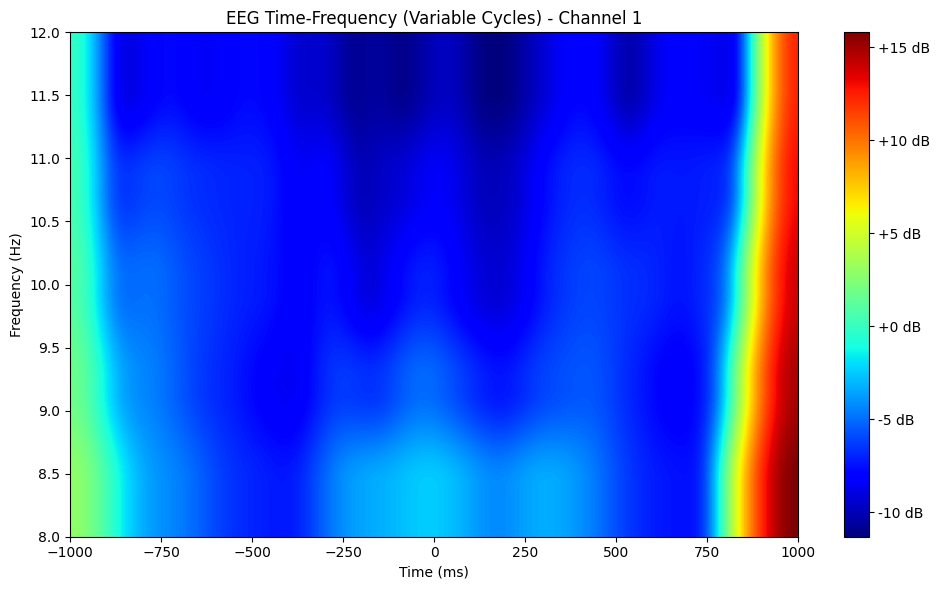

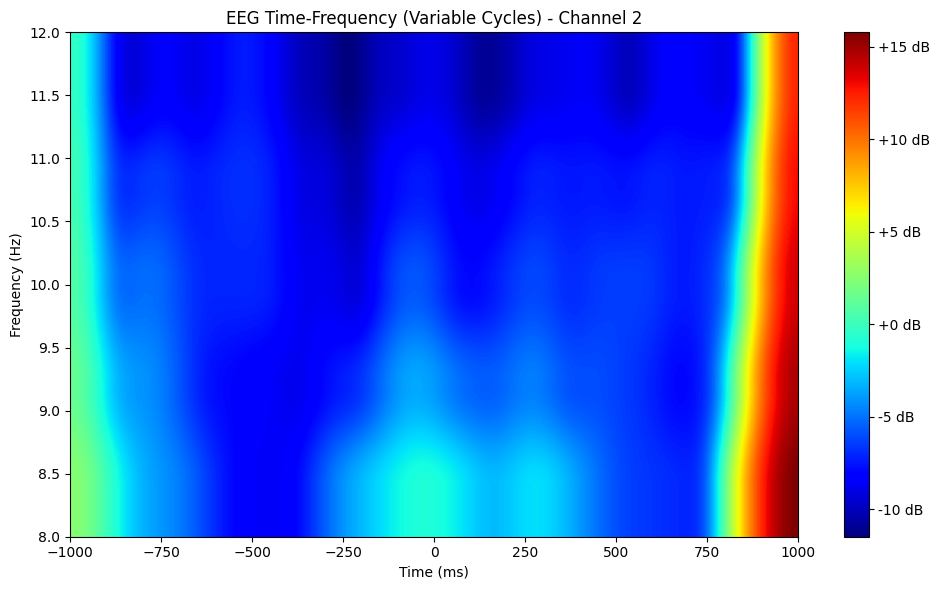

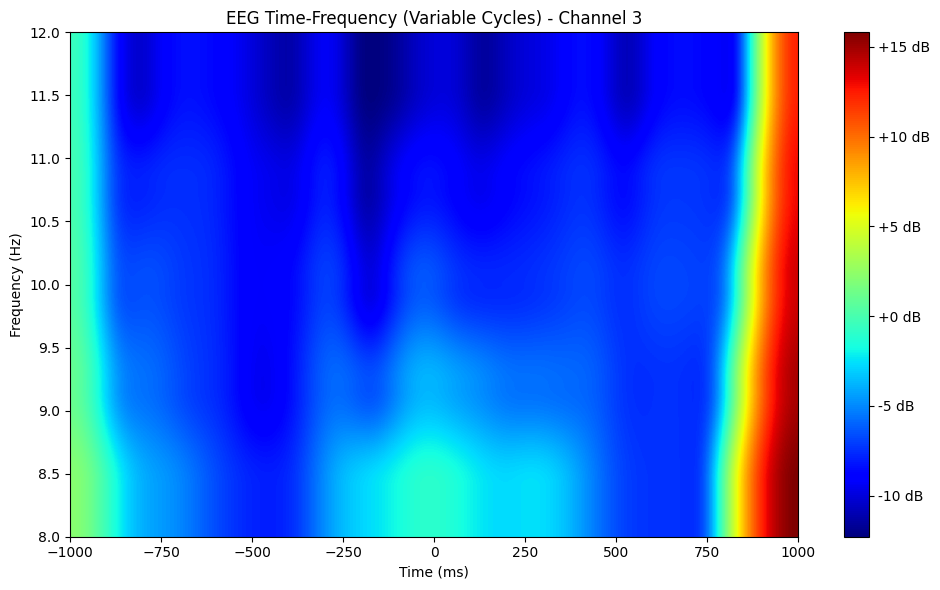

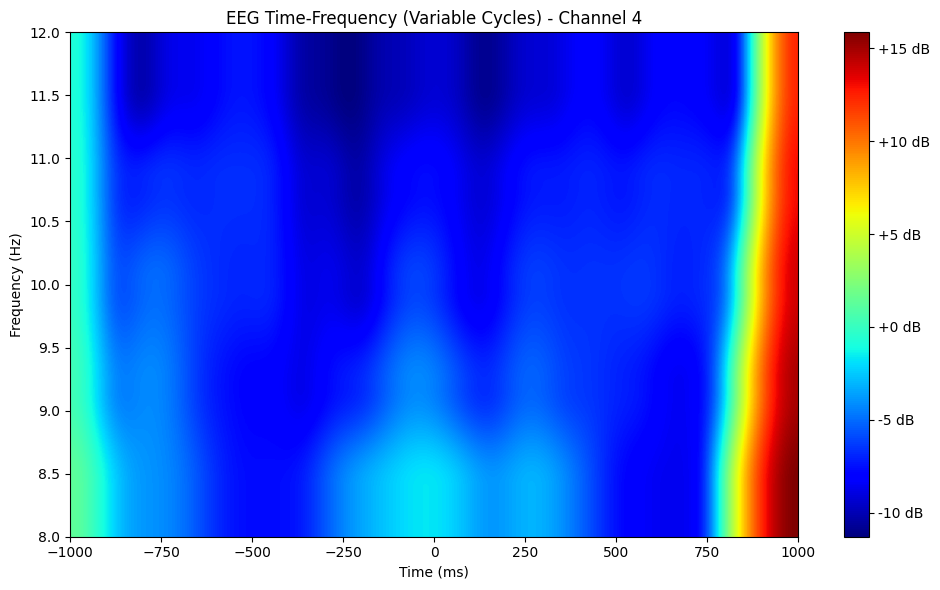

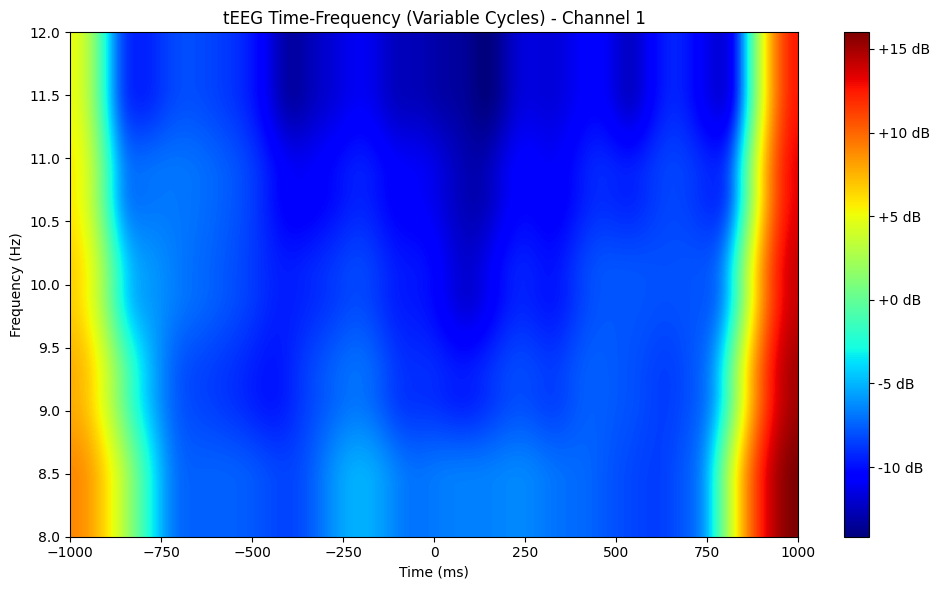

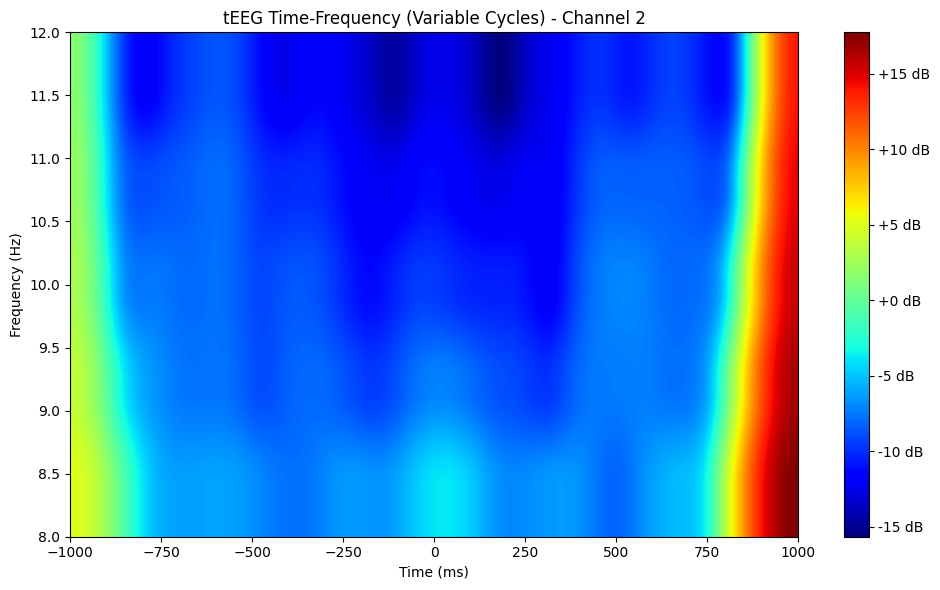

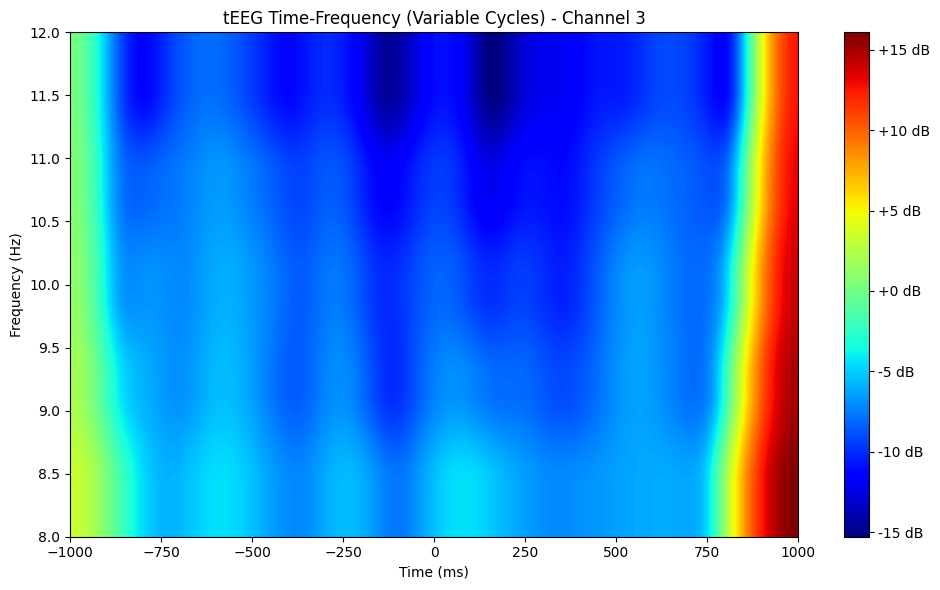

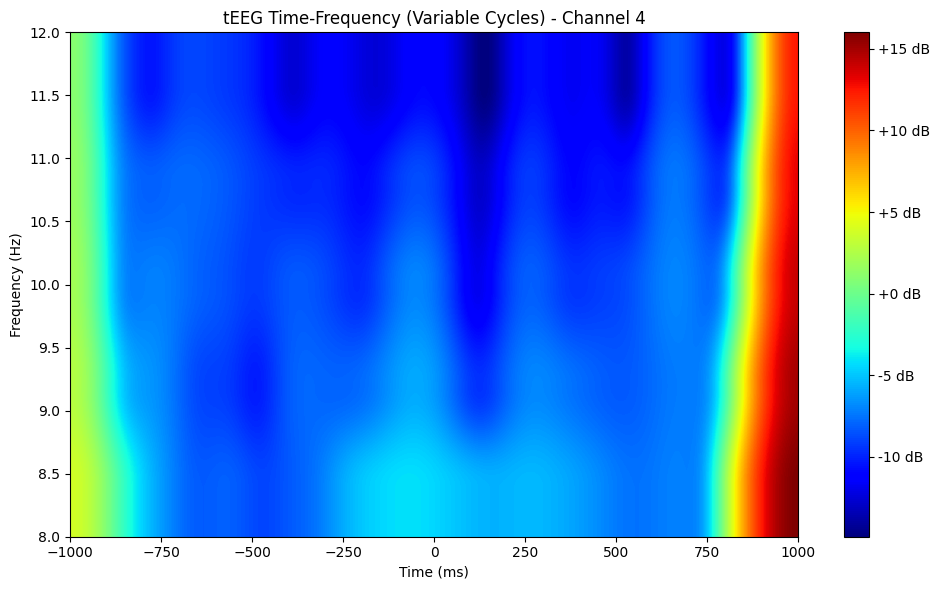

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Constants
frequencies = np.arange(8, 13, 1)  # 2 to 40 Hz
cycles = [4] * 20  # Variable cycles from 3 to 10
sampling_rate = 250


def calculate_power(data, cycles, frequencies):
    num_channels = data.shape[2]
    power_matrix = []

    for freq, cycle in zip(frequencies, cycles):

        # Calculate power for each trial and each channel
        power_trials_channels = []
        for ch in range(num_channels):
            power_trials = []
            for trial_idx in range(data.shape[0]):
                trial_data = data[trial_idx, :, ch]  # Extracting data for a given trial and channel
                wavelet = morlet_wavelet(freq, cycle, sampling_rate)
                convolution = convolve_with_wavelet(trial_data, wavelet)
                power = np.abs(convolution)**2
                power_trials.append(power)

            # Average power across trials for each channel
            avg_power = np.mean(power_trials, axis=0)
            power_trials_channels.append(avg_power)

        # Storing the average power for all channels
        power_matrix.append(power_trials_channels)

    return np.array(power_matrix)  # Shape: (frequencies, channels, timesteps)


eeg_power_variable_cycles = calculate_power(X_eeg_2, cycles, frequencies)
teeg_power_variable_cycles = calculate_power(X_tcre_2, cycles, frequencies)

# Plotting function
def plot_time_frequency(data, title, time_range, freqs):
    n_channels = data.shape[1]
    for ch in range(n_channels):
        plt.figure(figsize=(10, 6))
        plt.imshow(10 * np.log10(data[:, ch, :]), aspect='auto', cmap='jet', origin='lower',
                   extent=[time_range[0], time_range[1], freqs[0], freqs[-1]])  # Log transform of power; color limits as specified
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel('Time (ms)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f"{title} - Channel {ch + 1}")
        plt.tight_layout()
        plt.show()

# Modify time_range based on your data's time length
time_range = [-1000, 1000]
plot_time_frequency(eeg_power_variable_cycles, 'EEG Time-Frequency (Variable Cycles)', time_range, frequencies)
plot_time_frequency(teeg_power_variable_cycles, 'tEEG Time-Frequency (Variable Cycles)', time_range, frequencies)

# Test

In [ ]:
import os
from preprocessing import *

# Set the path for this subject
path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject3/task_3"

df = read_data_and_preprocessing(path, events=[0, 1, 2], denoise=50, FreqBands=True)

labels = df["events"].to_list()
df.drop(['events'], axis=1, inplace=True)

df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                    'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                    'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                    'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                    'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                    'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                    'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

# Get amplitude-based features from wavelet transform
features_eeg = get_amplitude_features_for_data(X_eeg)
features_tcre = get_amplitude_features_for_data(X_tcre)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for k-fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(C=50),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(n_estimators=20, learning_rate=0.05),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(C=50),
}



In [ ]:
clf = LogisticRegression(C=50)

accuracies_eeg = []
accuracies_tcre = []

for train_index, test_index in kf.split(features_eeg, y):
            X_train, X_test = features_eeg[train_index], features_eeg[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies_eeg.append(accuracy)

avg_accuracy_eeg = sum(accuracies_eeg) / n_splits

for train_index, test_index in kf.split(features_tcre, y):
            X_train, X_test = features_tcre[train_index], features_tcre[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies_tcre.append(accuracy)

avg_accuracy_tcre = sum(accuracies_tcre) / n_splits

print(f"EEG: {avg_accuracy_eeg}")
print(f"TCRE: {avg_accuracy_tcre}")

EEG: 0.7324358974358974
TCRE: 0.7728205128205128


# Classification

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for k-fold cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(C=50),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "XGBoost": xgb.XGBClassifier(n_estimators=20, learning_rate=0.05),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(C=50),
}



## Text to table

In [ ]:
# Initialize the nested dictionary structure
subjects = ["S1", "S2", "S3", "S4", "S5", "S6"]
scenarios = ["EEG", "Tripolar"]
models = ["Random Forest", "SVM", "KNN", "XGBoost", "LDA", "Logistic Regression"]

accuracies_dict = {}
for subj in subjects:
    accuracies_dict[subj] = {}
    for scenario in scenarios:
        accuracies_dict[subj][scenario] = {}
        for model in models:
            accuracies_dict[subj][scenario][model] = None

# Fill the dictionary with accuracies from the text file
with open("nomov_power.txt", "r") as file:
    lines = file.readlines()

current_subject = None
current_model = None
current_scn = None

for line in lines:
    # Identify the subject
    if "Processing data" in line:
        current_subject = f"S{line.split('subject')[-1].strip()}"
        continue
    # Identify the model
    elif any(f"Evaluating {model}" in line for model in models):
        current_model = line.split("Evaluating")[1].replace(":", "").strip()
        continue
    elif "EEG" in line:
        current_scn = "EEG"
        continue
    elif "Tripolar" in line:
        current_scn = "Tripolar"
        continue
    elif "Average Accuracy" in line:
        accuracy = float(line.split(":")[-1].replace("%", "").strip())
        accuracies_dict[current_subject][current_scn][current_model] = accuracy
        continue

# Convert nested dictionary to DataFrame for EEG
df_eeg = pd.DataFrame({subject: accuracies_dict[subject]['EEG'] for subject in subjects}).transpose()
df_tripolar = pd.DataFrame({subject: accuracies_dict[subject]['Tripolar'] for subject in subjects}).transpose()

# Combine EEG and Tripolar DataFrames
df_combined = pd.concat([df_eeg, df_tripolar], axis=1, keys=['EEG Acc(%)', 'TCRE Acc(%)'])

# Calculate the mean for each column and append to the DataFrame
mean_values = df_combined.mean(axis=0)
df_combined.loc["Mean"] = mean_values

# Export to Excel
df_combined.to_excel("nomov_power.xlsx", engine='openpyxl')
print("Data exported to accuracies.xlsx with mean values.")

## Multiclass Classification

In [ ]:
import os
from preprocessing import *

# Loop through subjects
for subject_num in range(1, 7):  # from subject1 to subject6
    print(f"\nProcessing data for subject{subject_num}")

    # Set the path for this subject
    path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1, 2], denoise=50, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
    X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

    log_text = []

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name}:\n" + "="*40)

        for data_name, features in data_types.items():

            accuracies = []

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")



Processing data for subject1

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 85.93%

 Tripolar - Random Forest:
Average Accuracy: 86.67%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 77.04%

 Tripolar - SVM:
Average Accuracy: 80.00%

Evaluating KNN:

 EEG - KNN:
Average Accuracy: 71.11%

 Tripolar - KNN:
Average Accuracy: 77.04%

Evaluating XGBoost:

 EEG - XGBoost:
Average Accuracy: 87.41%

 Tripolar - XGBoost:
Average Accuracy: 86.67%

Evaluating LDA:

 EEG - LDA:
Average Accuracy: 71.85%

 Tripolar - LDA:
Average Accuracy: 74.07%

Evaluating Logistic Regression:

 EEG - Logistic Regression:
Average Accuracy: 65.93%

 Tripolar - Logistic Regression:
Average Accuracy: 68.89%

Processing data for subject2

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 88.13%

 Tripolar - Random Forest:
Average Accuracy: 89.51%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 86.08%

 Tripolar - SVM:
Average Accuracy: 82.54%

Evaluating KNN:

 EEG - KNN:
Averag

In [ ]:
import os
from preprocessing import *

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Naive Bayes": GaussianNB()
}

# Create a directory for logs if it doesn't exist
log_dir = "/content/drive/MyDrive/Data/EEGdata_Tripolar/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Loop through subjects
for subject_num in range(4, 7):  # from subject1 to subject6
    print(f"Processing data for subject{subject_num}")

    # Set the path for this subject
    path = f"/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_ 4_channel/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1, 2], denoise=20, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
    X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)


    data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

    log_text = []

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name}:\n" + "="*40)

        for data_name, features in data_types.items():
            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Print results
            print(f"\nResults for {data_name} data:")
            print(f"Accuracy: {accuracy*100:.2f}%")
            print(classification_report(y_test, y_pred))

            # Append results to the log text
            log_text.append(f"\nResults for {data_name} data:")
            log_text.append(f"Accuracy: {accuracy*100:.2f}%")
            log_text.append(classification_report(y_test, y_pred))

    # Write results to a log file for this subject
    with open(os.path.join(log_dir, f"subject{subject_num}_results.log"), "w") as file:
        file.write("\n".join(log_text))


Processing data for subject4

Evaluating Random Forest:

Results for EEG data:
Accuracy: 97.06%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.94      0.94      0.94        18
           2       0.95      0.95      0.95        22

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68


Results for Tripolar data:
Accuracy: 98.53%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      0.94      0.97        18
           2       0.96      1.00      0.98        22

    accuracy                           0.99        68
   macro avg       0.99      0.98      0.98        68
weighted avg       0.99      0.99      0.99        68


Evaluating SVM:

Results for EEG data:
Accuracy: 79.41%
              precision    recall  f1-sc

In [ ]:
df

,P3_t,C3_t,C4_t,F5_t,P3_e,C3_e,C4_e,F5_e
0,-13.009948,-13.084232,-14.112832,-13.445781,-12.795815,-13.472672,-12.826933,-13.060221
1,-13.009948,-13.084232,-14.112832,-13.445781,-12.795815,-13.472672,-12.826933,-13.060221
2,-13.009948,-13.084232,-14.112832,-13.445781,-12.795815,-13.472672,-12.826933,-13.060221
3,-13.009948,-13.084232,-14.112832,-13.445781,-12.795815,-13.472672,-12.826933,-13.060221
4,-13.009948,-13.084232,-14.112832,-13.445781,-12.795815,-13.472672,-12.826933,-13.060221
...,...,...,...,...,...,...,...,...
300195,0.701124,-1.539752,1.922022,-3.867998,-1.461023,-1.532568,-1.430985,-1.606752
300196,0.700614,-1.500750,1.880816,-3.797922,-1.432902,-1.502814,-1.404123,-1.574106
300197,0.700614,-1.500750,1.880816,-3.797922,-1.432902,-1.502814,-1.404123,-1.574106
300198,0.700823,-1.459600,1.839220,-3.726674,-1.402664,-1.470987,-1.375614,-1.539431


In [ ]:
from preprocessing import *

# # Set the path for this subject
# path = f"/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_ 4_channel/Olivia/task_3"

# df = read_data_and_preprocessing(path, events=[0, 1, 2], low_f=0.5, high_f=40, denoise=50, detrend=True, FreqBands=True, minmax=False, zscore=True)

# labels = df["events"].to_list()
# df.drop(['events'], axis=1, inplace=True)

# df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
#                     'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
#                     'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
#                     'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

# df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
#                     'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
#                     'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
#                     'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

# X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
# X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

X_eeg, y = X_eeg[0:100], y[0:100]
X_tcre = X_tcre[0:100]

# Get amplitude-based features from wavelet transform
features_eeg = get_amplitude_features_for_data(X_eeg)
features_tcre = get_amplitude_features_for_data(X_tcre)

data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

log_text = []

# Loop through classifiers and data types
for clf_name, clf in classifiers.items():
    print(f"\nEvaluating {clf_name}:\n" + "="*40)

    for data_name, features in data_types.items():

        accuracies = []

        for train_index, test_index in kf.split(features, y):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Average accuracy across the folds
        avg_accuracy = sum(accuracies) / n_splits

        # Print and log results
        print(f"\n {data_name} - {clf_name}:")
        print(f"Average Accuracy: {avg_accuracy*100:.2f}%")


Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 76.00%

 Tripolar - Random Forest:
Average Accuracy: 75.00%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 76.00%

 Tripolar - SVM:
Average Accuracy: 68.00%

Evaluating KNN:

 EEG - KNN:
Average Accuracy: 75.00%

 Tripolar - KNN:
Average Accuracy: 71.00%

Evaluating XGBoost:

 EEG - XGBoost:
Average Accuracy: 76.00%

 Tripolar - XGBoost:
Average Accuracy: 75.00%

Evaluating LDA:

 EEG - LDA:
Average Accuracy: 52.00%

 Tripolar - LDA:
Average Accuracy: 47.00%

Evaluating Logistic Regression:

 EEG - Logistic Regression:
Average Accuracy: 69.00%

 Tripolar - Logistic Regression:
Average Accuracy: 66.00%


## Binary (No-movement vs Power Grasp)

In [ ]:
import os
from preprocessing import *

# Loop through subjects
for subject_num in range(1, 7):  # from subject1 to subject6
    print(f"\nProcessing data for subject{subject_num}")

    # Set the path for this subject
    path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 1], denoise=50, FreqBands=True)

    labels = df["events"].to_list()
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
    X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

    log_text = []

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name}:\n" + "="*40)

        for data_name, features in data_types.items():

            accuracies = []

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")



Processing data for subject1

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 88.89%

 Tripolar - Random Forest:
Average Accuracy: 87.78%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 81.11%

 Tripolar - SVM:
Average Accuracy: 87.78%

Evaluating KNN:

 EEG - KNN:
Average Accuracy: 77.78%

 Tripolar - KNN:
Average Accuracy: 83.33%

Evaluating XGBoost:

 EEG - XGBoost:
Average Accuracy: 80.00%

 Tripolar - XGBoost:
Average Accuracy: 80.00%

Evaluating LDA:

 EEG - LDA:
Average Accuracy: 78.89%

 Tripolar - LDA:
Average Accuracy: 84.44%

Evaluating Logistic Regression:

 EEG - Logistic Regression:
Average Accuracy: 68.89%

 Tripolar - Logistic Regression:
Average Accuracy: 75.56%

Processing data for subject2

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 91.63%

 Tripolar - Random Forest:
Average Accuracy: 90.53%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 93.68%

 Tripolar - SVM:
Average Accuracy: 89.53%

Evaluating KNN:

 EEG - KNN:
Averag

## Binary (No-move vs Precision)

In [ ]:
import os
from preprocessing import *

# Loop through subjects
for subject_num in range(1, 7):  # from subject1 to subject6
    print(f"\nProcessing data for subject{subject_num}")

    # Set the path for this subject
    path = f"/content/drive/MyDrive/Data/EEGdata_Tripolar/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[0, 2], denoise=50, FreqBands=True)

    labels = df["events"].to_list()
    labels = [1 if label == 2 else label for label in labels]
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
    X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)

    data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

    log_text = []

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name}:\n" + "="*40)

        for data_name, features in data_types.items():

            accuracies = []

            for train_index, test_index in kf.split(features, y):
                X_train, X_test = features[train_index], features[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on the test set
                y_pred = clf.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)

            # Average accuracy across the folds
            avg_accuracy = sum(accuracies) / n_splits

            # Print and log results
            print(f"\n {data_name} - {clf_name}:")
            print(f"Average Accuracy: {avg_accuracy*100:.2f}%")



Processing data for subject1

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 91.11%

 Tripolar - Random Forest:
Average Accuracy: 93.33%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 81.11%

 Tripolar - SVM:
Average Accuracy: 81.11%

Evaluating KNN:

 EEG - KNN:
Average Accuracy: 76.67%

 Tripolar - KNN:
Average Accuracy: 80.00%

Evaluating XGBoost:

 EEG - XGBoost:
Average Accuracy: 75.56%

 Tripolar - XGBoost:
Average Accuracy: 77.78%

Evaluating LDA:

 EEG - LDA:
Average Accuracy: 80.00%

 Tripolar - LDA:
Average Accuracy: 74.44%

Evaluating Logistic Regression:

 EEG - Logistic Regression:
Average Accuracy: 80.00%

 Tripolar - Logistic Regression:
Average Accuracy: 75.56%

Processing data for subject2

Evaluating Random Forest:

 EEG - Random Forest:
Average Accuracy: 85.37%

 Tripolar - Random Forest:
Average Accuracy: 91.58%

Evaluating SVM:

 EEG - SVM:
Average Accuracy: 85.37%

 Tripolar - SVM:
Average Accuracy: 80.26%

Evaluating KNN:

 EEG - KNN:
Averag

## Binary (Power vs Precision)

In [ ]:
import os
from preprocessing import *

# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Naive Bayes": GaussianNB()
}

# Create a directory for logs if it doesn't exist
log_dir = "/content/drive/MyDrive/Data/EEGdata_Tripolar/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Loop through subjects
for subject_num in range(1, 7):  # from subject1 to subject6
    print(f"Processing data for subject{subject_num}")

    # Set the path for this subject
    path = f"/content/drive/Shareddrives/TNLabAnalysis_VisionBasedGrasping/Tripolar_ 4_channel/subject{subject_num}/task_3"

    df = read_data_and_preprocessing(path, events=[1, 2], denoise=50, FreqBands=True)

    labels = df["events"].to_list()
    labels = [i - 1 for i in labels]
    df.drop(['events'], axis=1, inplace=True)

    df_tcre = df.loc[:, ['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                        'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                        'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                        'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma']]

    df_eeg = df.loc[:, ['P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                        'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                        'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                        'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma']]

    X_eeg, y = prepare_data(df_eeg, win_size=1501, labels=labels, time_win=((501, 1001)))
    X_tcre, _ = prepare_data(df_tcre, win_size=1501, labels=labels, time_win=((501, 1001)))

    # Get amplitude-based features from wavelet transform
    features_eeg = get_amplitude_features_for_data(X_eeg)
    features_tcre = get_amplitude_features_for_data(X_tcre)


    data_types = {"EEG": features_eeg, "Tripolar": features_tcre}

    log_text = []

    # Loop through classifiers and data types
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name}:\n" + "="*40)

        for data_name, features in data_types.items():
            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42)

            # Train the classifier
            clf.fit(X_train, y_train)

            # Predict on the test set
            y_pred = clf.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # Print results
            print(f"\nResults for {data_name} data:")
            print(f"Accuracy: {accuracy*100:.2f}%")
            print(classification_report(y_test, y_pred))

            # Append results to the log text
            log_text.append(f"\nResults for {data_name} data:")
            log_text.append(f"Accuracy: {accuracy*100:.2f}%")
            log_text.append(classification_report(y_test, y_pred))

    # Write results to a log file for this subject
    with open(os.path.join(log_dir, f"subject{subject_num}_results.log"), "w") as file:
        file.write("\n".join(log_text))